# Cluster face embeddings

**Goal** is to select best clustering algorithm to cluster face embeddings into distinct persons.

Options are:

    DBscan
    Chinese whispers
    Hierarchical

In [1]:
import pickle
import numpy as np

import sys, os

from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
project_dir = os.path.dirname(os.path.realpath(os.path.curdir))
if project_dir not in sys.path:
    sys.path.insert(0, project_dir)

### Load Data

In [3]:
FILE = '../data/interim/embeddings/mobilenet_dlib_06-21.pkl'

In [4]:
with open(FILE, 'rb') as f:
    data = pickle.load(f)

In [5]:
len(data)

1749

##### Visualize

In [6]:
N_SHOW = 10

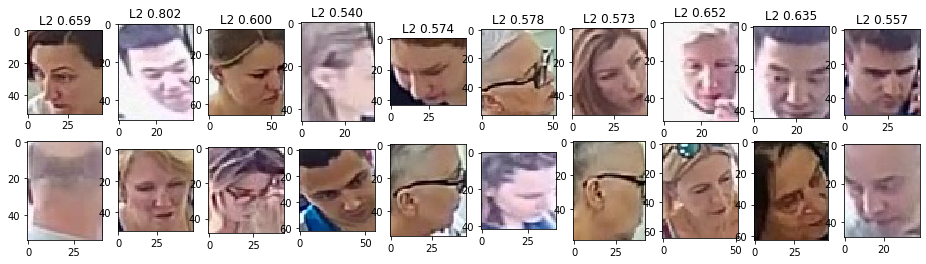

In [7]:
fig,ax = plt.subplots(2, N_SHOW, sharex=False, sharey=False, figsize=(16,4))

for n in range(N_SHOW):
    i = np.random.randint(len(data))
    j = np.random.randint(len(data))
    i_img = plt.imread(os.path.join(project_dir, data[i][0]))
    j_img = plt.imread(os.path.join(project_dir, data[j][0]))
    ax[0,n].imshow(i_img)
    ax[1,n].imshow(j_img)
    l2 = np.linalg.norm(data[i][1] - data[j][1], ord=2)
    ax[0,n].set_title(f'L2 {l2:.3f}')

plt.show()

##### Get embeddings and paths

In [8]:
embeddings = np.array([d[1] for d in data])
embeddings.shape

(1749, 128)

In [9]:
image_paths = [d[0] for d in data]

len(image_paths)

1749

### Clustering algorithms

In [10]:
from itertools import combinations

from sklearn.metrics import silhouette_score, pairwise_distances

from sklearn.cluster import DBSCAN
from scipy.cluster import hierarchy

import cv2

import networkx as nx
import dlib

In [11]:
from src.chinese_whispers import chinese_whispers, aggregate_clusters

In [12]:
def cluster_results(features, labels):
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noize = (labels == -1).sum()
    score = silhouette_score(features, labels)
    print(f'Number of clusters: {n_clusters}')
    print(f'Number of noizy points: {n_noize/len(labels):.3f}')
    print(f'Silhouette score: {score}')
    
    
def hierarchical_clustering(features, threshold, dist_type='euclidean',
                          linkage_method='complete',):
    '''
    Cluster customer features until number of unique customers is less
    than max_unique. Each step increase starting threshold with increment
    return cluster indices
    '''
    link_matrix = hierarchy.linkage(features, metric=dist_type, 
                                    method=linkage_method)
    cluster_labels = hierarchy.fcluster(link_matrix, threshold, 
                                        criterion='distance')
    return cluster_labels    


def plot_clustered_faces(cluster_labels, image_paths, n_show, max_rows=10,
                         fig_size=(10,15)):
    labels = list(set(cluster_labels))
    if len(labels) > max_rows:
        labels = np.random.choice(labels, size=max_rows).tolist()
    image_paths = np.array(image_paths)
    fig,axes = plt.subplots(len(labels), n_show, sharex=False, sharey=False, figsize=fig_size)
    [ax.set_axis_off() for ax in axes.ravel()]
    for row,lab in enumerate(labels):
        images_in_cluster = image_paths[cluster_labels == lab]
        selected_images = np.random.choice(images_in_cluster, size=min(n_show, len(images_in_cluster)), 
                                           replace=False)
        for col,img in enumerate(selected_images):
            bgr = cv2.imread(os.path.join(project_dir, img))
            rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
            axes[row, col].imshow(rgb)
            if col == 0:
                axes[row, col].set_title(f'Cluster {lab}')
            axes[row, col].axis('off')
    plt.show()

def abnormal_labels(cluster_labels, min_num, max_num):
    '''
    Finds number of clusters with number of members 
    less than min_num or more than max_num
    '''
    labs,cnts = np.unique(cluster_labels, return_counts=True)
    num_small = len(labs[cnts < min_num])
    big = labs[cnts > max_num]
    num_big = len(big)
    big_percent = cnts[labs == big].sum() / len(cluster_labels)
    print(f'Small {num_small}, big {num_big}')
    print(f'Percentage of noize {big_percent:.4f}')

##### dbscan

In [13]:
dbs = DBSCAN(eps=0.25, min_samples=2, n_jobs=-1)

dbs.fit(embeddings)

DBSCAN(algorithm='auto', eps=0.25, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=2, n_jobs=-1, p=None)

In [14]:
cluster_results(embeddings, dbs.labels_)

Number of clusters: 173
Number of noizy points: 0.622
Silhouette score: -0.11117628717602916


In [16]:
abnormal_labels(dbs.labels_, 2, len(dbs.labels_)//3)

Small 0, big 1
Percentage of noize 0.6221


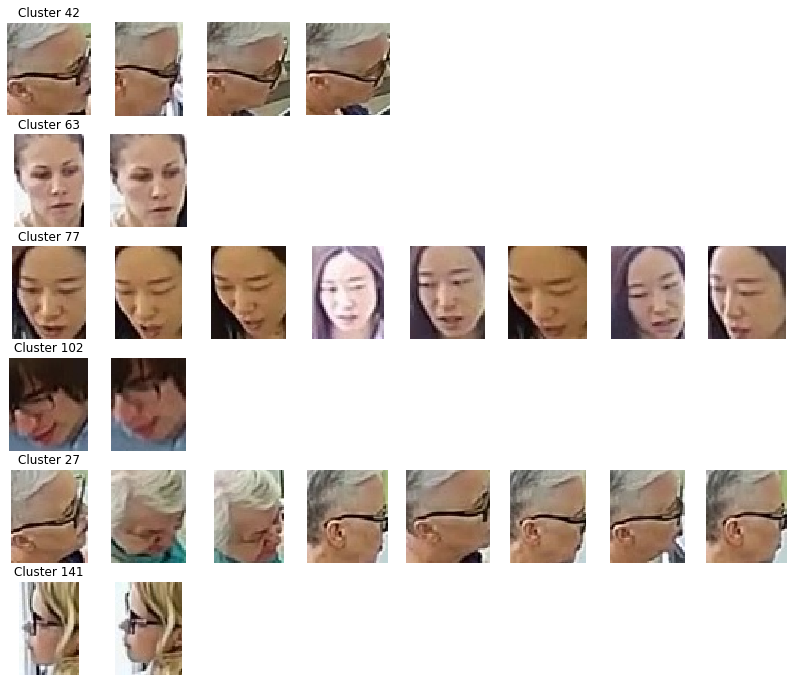

In [17]:
plot_clustered_faces(dbs.labels_, image_paths, 8, max_rows=6, fig_size=(14, 12))

##### hierarchical

In [18]:
h_labels = hierarchical_clustering(embeddings, 0.55, )

In [19]:
cluster_results(embeddings, h_labels)

Number of clusters: 160
Number of noizy points: 0.000
Silhouette score: 0.09882188159394169


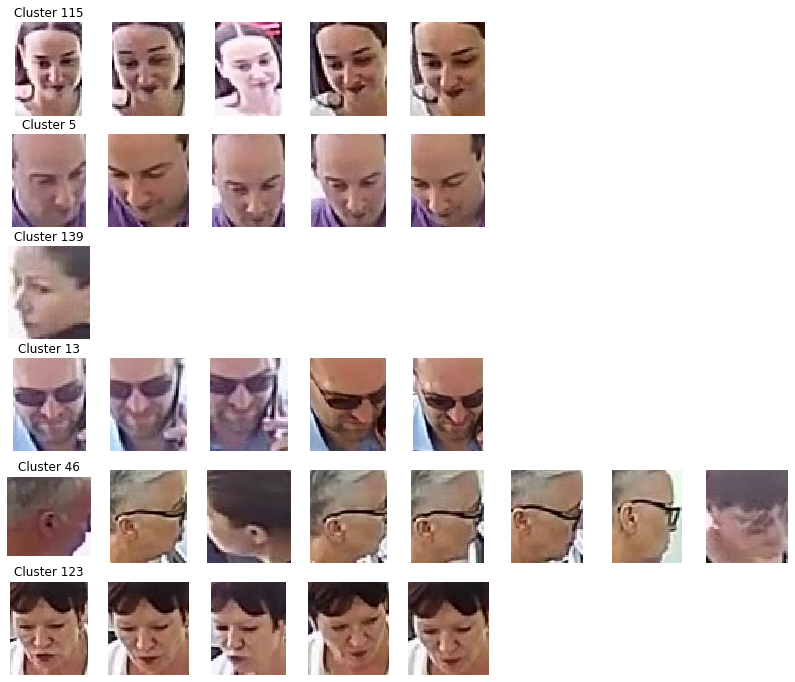

In [20]:
plot_clustered_faces(h_labels, image_paths, 8, max_rows=6, fig_size=(14, 12))

##### chinese whispers

In [27]:
import dlib

In [28]:
emb_dlib = [dlib.vector(e) for e in embeddings]

In [34]:
cw_labels = dlib.chinese_whispers_clustering(emb_dlib, 0.4)

cw_labels = np.array(cw_labels)

In [35]:
cluster_results(embeddings, cw_labels)

Number of clusters: 147
Number of noizy points: 0.000
Silhouette score: 0.0417403881519799


In [36]:
abnormal_labels(cw_labels, 2, len(embeddings)//3)

Small 61, big 1
Percentage of noize 0.6650


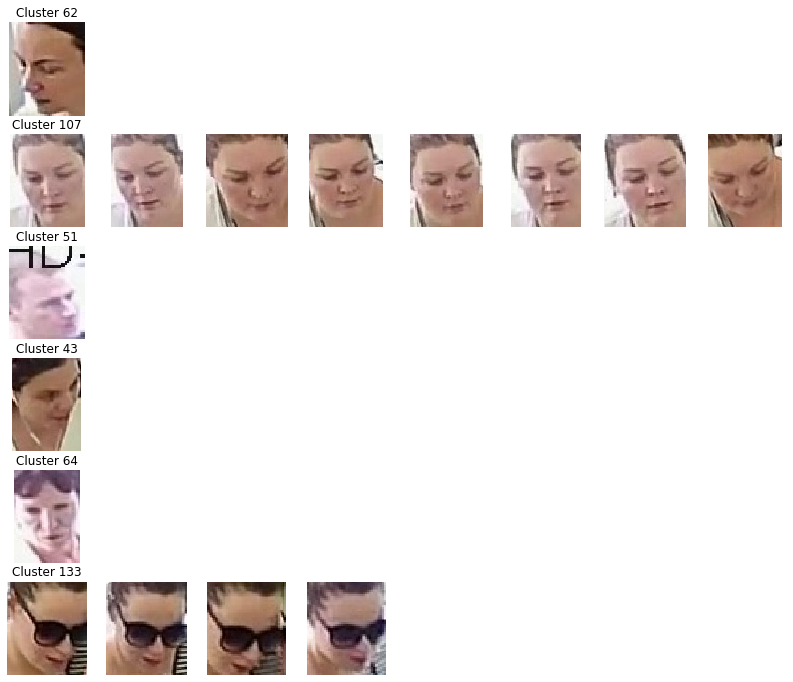

In [37]:
plot_clustered_faces(cw_labels, image_paths, 8, max_rows=6, fig_size=(14, 12))